# Context Assignment

### Data source : [Bike Sharing Data]('https://www.kaggle.com/gauravduttakiit/bike-sharing')
<br/>
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return 
back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return 
back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of 
over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, 
environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by
these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration
of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into
a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important
events in the city could be detected via monitoring these data.
<br/>
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 
<br/>
### Data Info 
<br/>
- instan : number<br/>
- season : represent season such as winter, spring etc<br/>
- yr     : represent years<br/>
- mnth   : represent mounth<br/>
- holiday : represent holiday ( 0 = no, 1 = yes)<br/>
- weekday : unique number represent the days of the week<br/>
- workingday : represent working day ( 0 = no, 1 = yes)<br/>
- weathersit : represent weather situation of the day<br/>
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)<br/>
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)<br/>
- hum: Normalized humidity. The values are divided to 100 (max)<br/>
- windspeed: Normalized wind speed. The values are divided to 67 (max)<br/>
- casual: count of casual users<br/>
- registered: count of registered users<br/>
- cnt: count of total rental bikes including both casual and registered<br/>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Library & Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_raw = pd.read_csv('/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/Daily Bike Sharing.csv',index_col = 'dteday', parse_dates=True)
df_raw.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Selecting important variables

In [4]:
df = df_raw[["cnt", "holiday", "workingday", "weathersit","temp", "atemp", "hum", "windspeed"]]

In [5]:
df.head(1)

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


transform the data to daily frequency. this is important because when our forcasting model are reading our dependence variable they will know that we are talking about daily frequency.

In [6]:
df = df.asfreq("D")
df.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

# Time Series Visualization

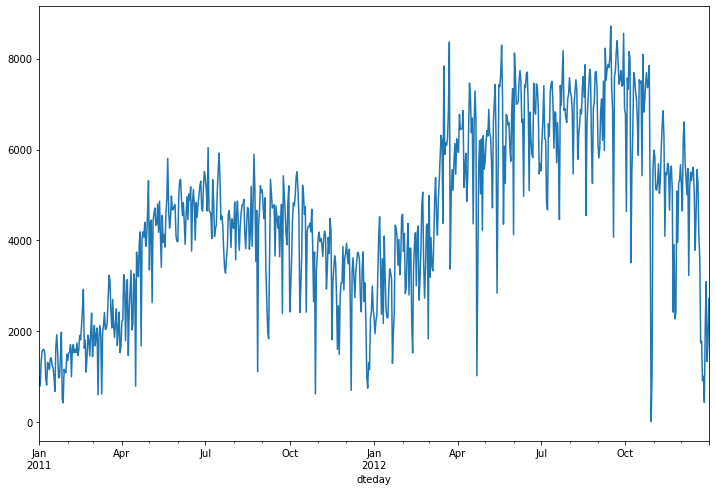

In [7]:
df["cnt"].plot(figsize = (12,8))

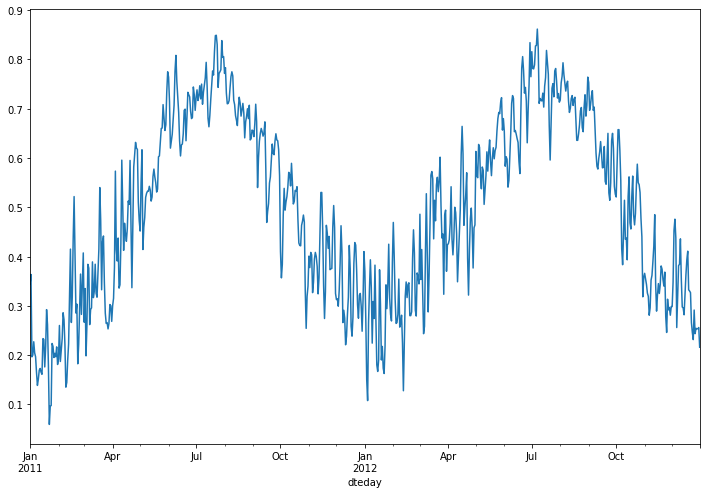

In [8]:
df["temp"].plot(figsize = (12,8))

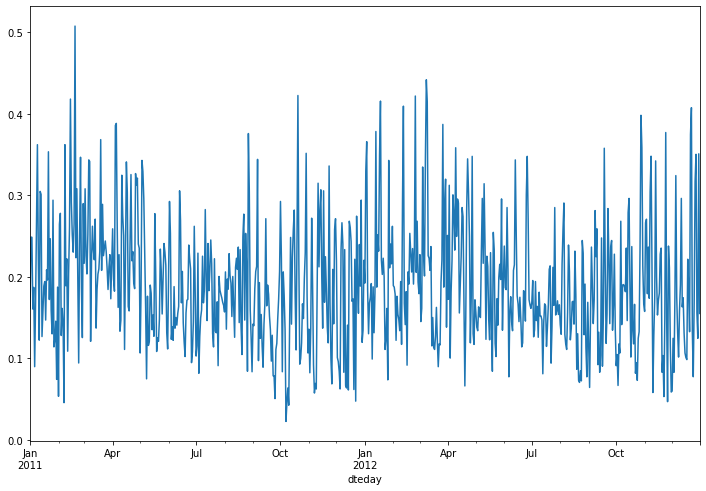

In [9]:
df["windspeed"].plot(figsize = (12,8))

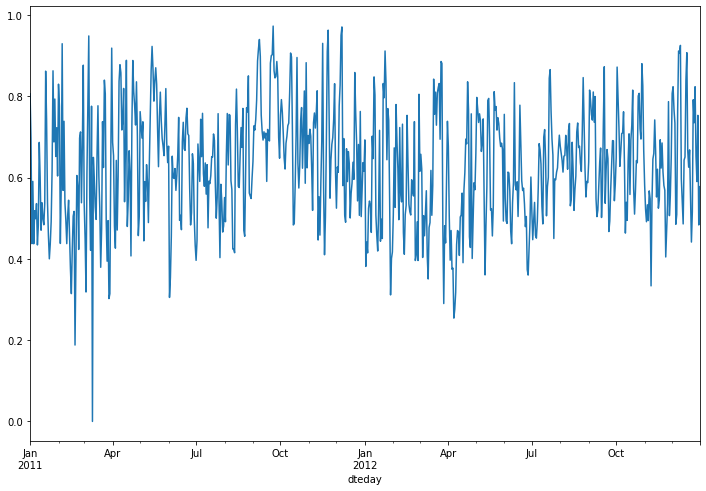

In [10]:
df["hum"].plot(figsize = (12,8))

# Seasonal Decomposition

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


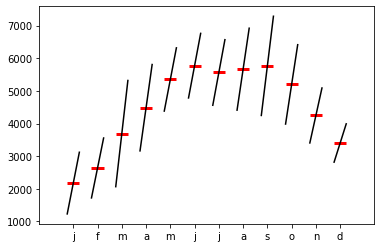

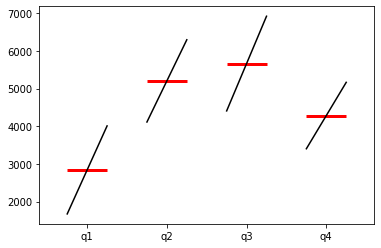

In [11]:
#seasonality graphs
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
month_plot(df['cnt'].resample(rule = 'MS').mean())
quarter_plot(df['cnt'].resample(rule = 'Q').mean());

the black line are meant to represent the volatility of that given mounth and the red line is the avarage of the data. desember is the least amount of volatilty, i think in desember the amount of people use bike sharing simply it's the weather not warm enough

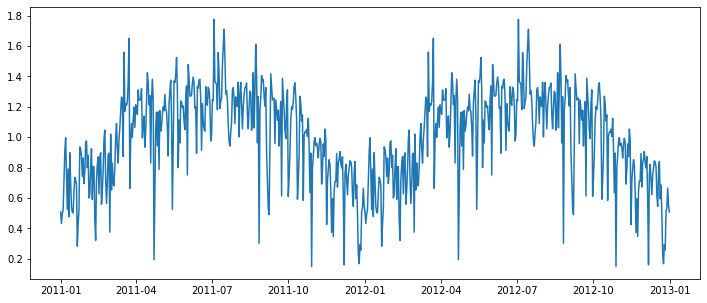

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['cnt'],model = 'multiplicative',freq=365)
plt.figure(figsize=(12,5))
plt.plot(decomposition.seasonal)

Seasonality: The repeating short-term cycle in the series.

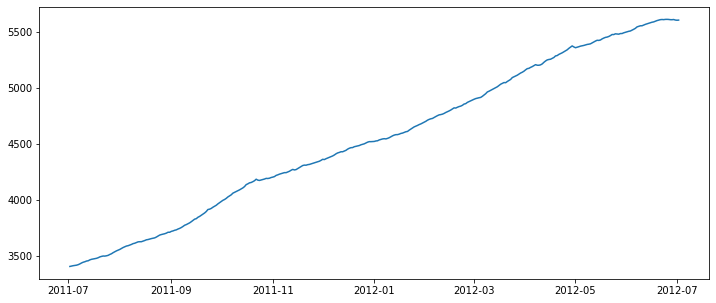

In [14]:
plt.figure(figsize=(12,5))
plt.plot(decomposition.trend)

Trend: The increasing or decreasing value in the series.

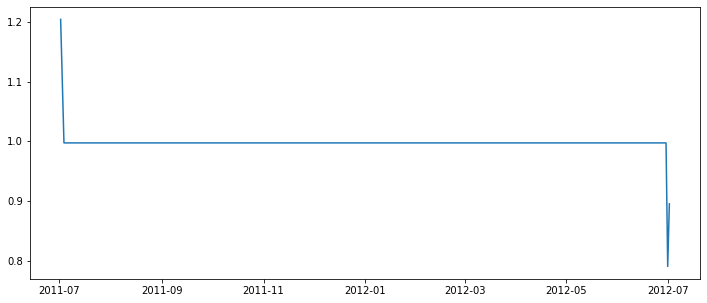

In [15]:
plt.figure(figsize=(12,5))
plt.plot(decomposition.resid)

Noise: The random variation in the series.

# Holt Winters

In [17]:
test_days = 31
training_set = df.iloc[:-test_days,:]
test_set = df.iloc[-test_days:,:]
test_set.head(1)

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-01,5191,0,0,2,0.298333,0.316904,0.806667,0.059704


In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(training_set['cnt'],
                             trend = 'mul',
                             seasonal = 'mul',
                             seasonal_periods = 7).fit()

if the trend graph is more stright line i will choose additive instead of multiplicative. however since we just have two period it does not matter which one you choose because the difference is not that big.

In [20]:
#predictions 
predictions = model.forecast(steps = len(test_set)).rename("HW")
predictions.head()

2012-12-01    4834.729863
2012-12-02    4433.017007
2012-12-03    4465.567184
2012-12-04    4626.723243
2012-12-05    4743.843081
Freq: D, Name: HW, dtype: float64

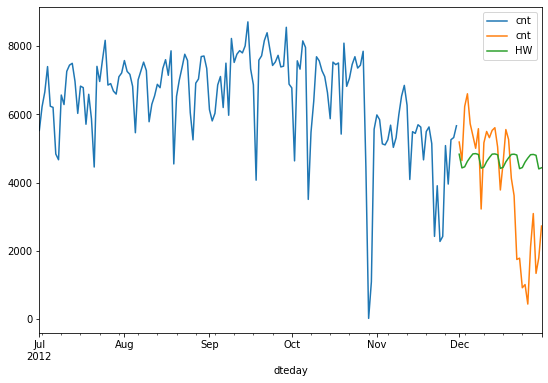

In [23]:
#plotting
training_set['cnt']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['cnt'].plot(legend = True)
predictions.plot(legend = True)

as you can see the Holt Winters isn't good enough for predicting because holt winters is too simple approach

# Model Evaluation

In [32]:
#MAE
from sklearn.metrics import mean_absolute_error
MAE = round(mean_absolute_error(test_set['cnt'], predictions),2) 

In [31]:
#MAPE
def MAPE (y_true,y_pred):
  y_true,y_pred = np.array(y_true),np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

MAPE = round(MAPE(test_set['cnt'],predictions),2)

In [33]:
print(f'the score of MAE is {MAE} and the precentage MAE is {MAPE}. the more small the MAE and MAPE is the more good the model')

the score of MAE is 1460.42 and the precentage MAE is 96.75. the more small the MAE and MAPE is the more good the model
